# EDA

## Step 1: Setup and Data Loading

We begin by installing the required libraries: `pyspark` for distributed data processing and `ucimlrepo` to fetch datasets from the UCI Machine Learning Repository. After initializing a Spark session, we download the CDC Diabetes Health Indicators dataset (UCI dataset ID 891), combine its features and labels into one DataFrame using pandas, and convert it to a Spark DataFrame for analysis.

The final `printSchema()` shows the structure and types of all columns in the dataset.


In [ ]:
# Install required packages
!pip install pyspark ucimlrepo --quiet

# Import libraries
from pyspark.sql import SparkSession
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("BRFSS EDA").getOrCreate()

# Fetch dataset from UCI and prepare it
diabetes_health_indicators = fetch_ucirepo(id=891)
data = pd.concat(
    [diabetes_health_indicators.data.features, diabetes_health_indicators.data.targets],
    axis=1
)

# Convert to Spark DataFrame
df = spark.createDataFrame(data)
df.printSchema()


root
 |-- HighBP: long (nullable = true)
 |-- HighChol: long (nullable = true)
 |-- CholCheck: long (nullable = true)
 |-- BMI: long (nullable = true)
 |-- Smoker: long (nullable = true)
 |-- Stroke: long (nullable = true)
 |-- HeartDiseaseorAttack: long (nullable = true)
 |-- PhysActivity: long (nullable = true)
 |-- Fruits: long (nullable = true)
 |-- Veggies: long (nullable = true)
 |-- HvyAlcoholConsump: long (nullable = true)
 |-- AnyHealthcare: long (nullable = true)
 |-- NoDocbcCost: long (nullable = true)
 |-- GenHlth: long (nullable = true)
 |-- MentHlth: long (nullable = true)
 |-- PhysHlth: long (nullable = true)
 |-- DiffWalk: long (nullable = true)
 |-- Sex: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Education: long (nullable = true)
 |-- Income: long (nullable = true)
 |-- Diabetes_binary: long (nullable = true)



## Step 2: Preview and Summary Statistics

In this step, we inspect the contents of the dataset and get an initial feel for the data.

- `df.show(5)` displays the top 5 rows to verify the data was loaded correctly.
- `df.describe().show()` computes summary statistics (count, mean, stddev, min, max) for each numeric column. This helps us understand the range, distribution, and potential outliers in the data.

These steps are important to establish a baseline understanding of the dataset before diving into analysis or modeling.


In [ ]:
# Show the first few rows of the dataset
df.show(5)

# Display basic descriptive statistics
df.describe().show()

+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+---------------+
|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|Diabetes_binary|
+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+---------------+
|     1|       1|        1| 40|     1|     0|                   0|           0|     0|      1|                0|            1|          0|      5|      18|      15|       1|  0|  9|        4|     3|              0|
|     0|       0|        0| 25|     1|     0|                   0|           1|     0|      0|                0|            0|          1|  

## Step 3: Checking for Missing Values

Missing data can affect model performance or analysis, so we need to identify any columns that contain `null` or `NaN` values.

This code uses PySpark functions:
- `isNull()` checks for null values.
- `isnan()` checks for NaN values (specific to numerical columns).
- `when(...).alias(c)` counts the occurrences per column.

If all counts return zero, our dataset is clean. If not, we’ll decide how to handle them (e.g., imputation or dropping).


In [ ]:
from pyspark.sql.functions import col, isnan, when, count

# Check for null or NaN values in all columns
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()


+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+---------------+
|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|Diabetes_binary|
+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+---------------+
|     0|       0|        0|  0|     0|     0|                   0|           0|     0|      0|                0|            0|          0|      0|       0|       0|       0|  0|  0|        0|     0|              0|
+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+--

## Step 4: Exploring Categorical Feature Distributions

To understand the composition of our dataset, we explore how values are distributed in key categorical features. Most of these are binary indicators (e.g., 0 = No, 1 = Yes).

This helps us:
- Identify dominant classes (e.g., if most people don’t have high BP or cholesterol).
- Spot class imbalance in the target variable (`Diabetes_binary`).
- Recognize potentially skewed features that could affect model training.

We group by each column and count how many entries fall into each category.


In [ ]:
# List of categorical/binary variables to explore
categorical_cols = [
    "HighBP", "HighChol", "Smoker", "Stroke", "HeartDiseaseorAttack",
    "PhysActivity", "AnyHealthcare", "NoDocbcCost", "Sex", "Diabetes_binary"
]

# Loop through and show value counts
for col_name in categorical_cols:
    print(f"Value counts for: {col_name}")
    df.groupBy(col_name).count().orderBy(col_name).show()


Value counts for: HighBP
+------+------+
|HighBP| count|
+------+------+
|     0|144851|
|     1|108829|
+------+------+

Value counts for: HighChol
+--------+------+
|HighChol| count|
+--------+------+
|       0|146089|
|       1|107591|
+--------+------+

Value counts for: Smoker
+------+------+
|Smoker| count|
+------+------+
|     0|141257|
|     1|112423|
+------+------+

Value counts for: Stroke
+------+------+
|Stroke| count|
+------+------+
|     0|243388|
|     1| 10292|
+------+------+

Value counts for: HeartDiseaseorAttack
+--------------------+------+
|HeartDiseaseorAttack| count|
+--------------------+------+
|                   0|229787|
|                   1| 23893|
+--------------------+------+

Value counts for: PhysActivity
+------------+------+
|PhysActivity| count|
+------------+------+
|           0| 61760|
|           1|191920|
+------------+------+

Value counts for: AnyHealthcare
+-------------+------+
|AnyHealthcare| count|
+-------------+------+
|            

## Step 5: Summary of Numerical Features

Next, we focus on numerical and ordinal variables like `BMI`, `Mental Health Days`, `Physical Health Days`, and `Age`. These features can often carry meaningful signals about health status and risks.

We use `.describe()` on each column to extract:
- Count of non-null entries
- Mean and standard deviation
- Minimum and maximum values

These insights help us detect outliers (like extreme BMI or age values), skewness in mental or physical health distributions, and potential needs for feature normalization or transformation in future steps.

In [ ]:
numerical_cols = ["BMI", "MentHlth", "PhysHlth", "Age"]

for col_name in numerical_cols:
    print(f"Summary statistics for: {col_name}")
    df.select(col_name).describe().show()


Summary statistics for: BMI
+-------+------------------+
|summary|               BMI|
+-------+------------------+
|  count|            253680|
|   mean|28.382363607694735|
| stddev| 6.608694201406025|
|    min|                12|
|    max|                98|
+-------+------------------+

Summary statistics for: MentHlth
+-------+------------------+
|summary|          MentHlth|
+-------+------------------+
|  count|            253680|
|   mean|3.1847721538946705|
| stddev|  7.41284669619621|
|    min|                 0|
|    max|                30|
+-------+------------------+

Summary statistics for: PhysHlth
+-------+------------------+
|summary|          PhysHlth|
+-------+------------------+
|  count|            253680|
|   mean|4.2420805739514345|
| stddev| 8.717951307175168|
|    min|                 0|
|    max|                30|
+-------+------------------+

Summary statistics for: Age
+-------+------------------+
|summary|               Age|
+-------+------------------+
|  co

## Step 6: Visualizing Distributions of Numerical Features

We use histograms to visualize the distributions of our continuous/ordinal variables. This helps us:

- Detect skewness in variables like `MentHlth` and `PhysHlth`
- Identify outliers in `BMI` (e.g., extremely high values)
- Understand the spread of `Age` groups

Visual inspection often reveals things summary statistics can’t — and it’s great for storytelling too.

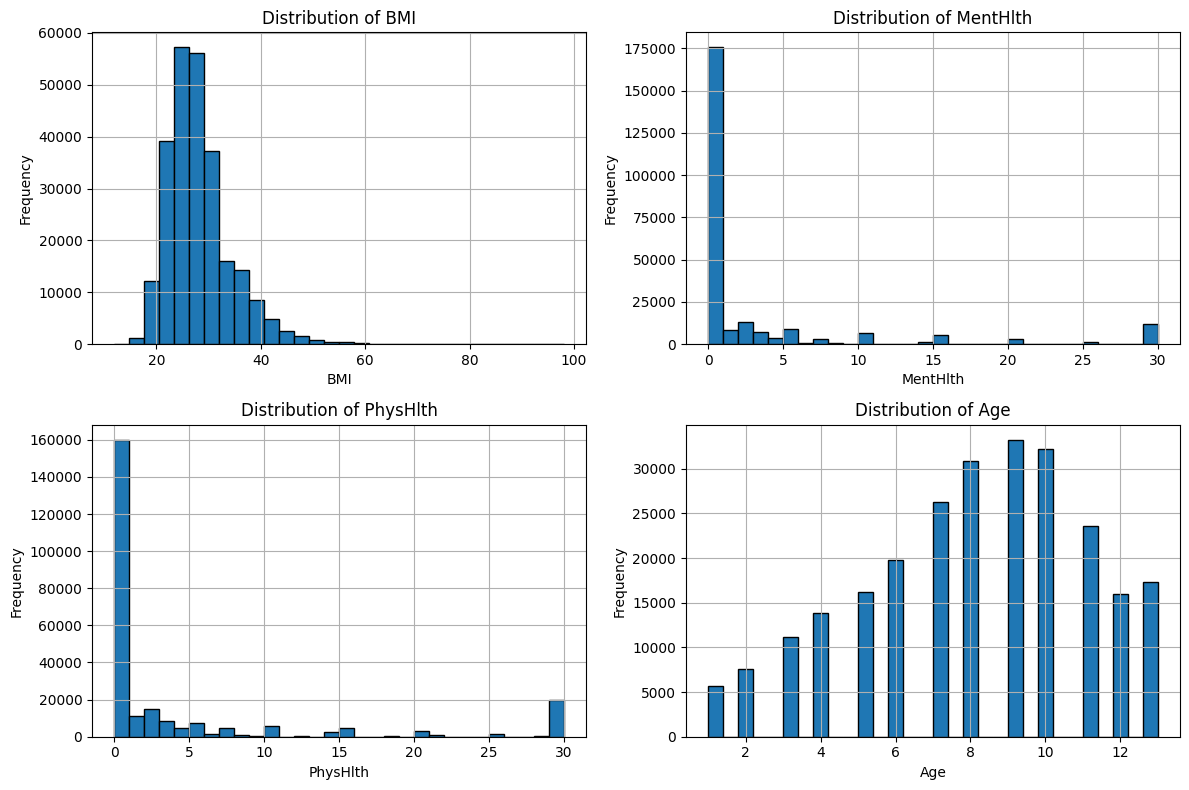

In [ ]:
# Convert select columns to Pandas for visualization
pdf = df.select("BMI", "MentHlth", "PhysHlth", "Age").toPandas()

import matplotlib.pyplot as plt

# Plot histograms for each numerical feature
plt.figure(figsize=(12, 8))
for i, col in enumerate(pdf.columns):
    plt.subplot(2, 2, i + 1)
    plt.hist(pdf[col], bins=30, edgecolor='k')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Step 7: Ordinal Feature Distributions — Education and Income

While not truly continuous, `Education` and `Income` are **ordinal variables**. Their values represent levels of education attained and income brackets, respectively.

Visualizing their distributions helps us:
- Understand population makeup
- Identify socioeconomic skew
- See potential health access disparities

We sort and plot frequency counts using bar charts for interpretability.

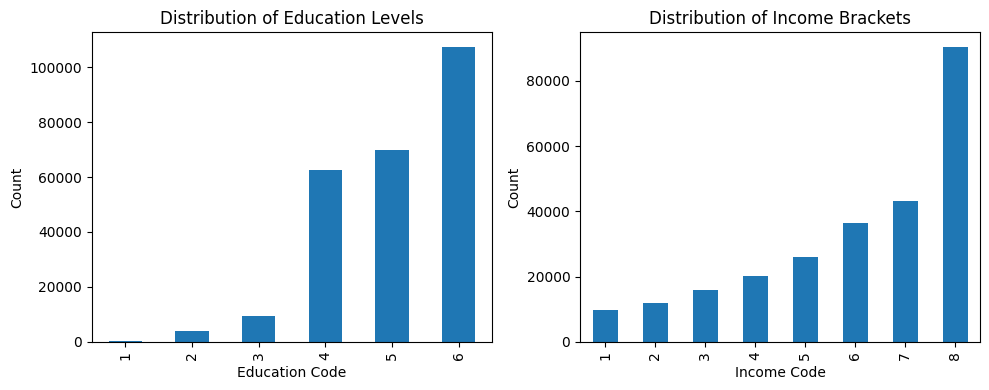

In [ ]:
# Pull ordinal features into pandas
pdf_ord = df.select("Education", "Income").toPandas()

# Bar plots for Education and Income
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
pdf_ord['Education'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Education Levels")
plt.xlabel("Education Code")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
pdf_ord['Income'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Income Brackets")
plt.xlabel("Income Code")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


## Step 8: Correlation Matrix

We plot a correlation matrix to evaluate how features relate to each other — and to our target, `Diabetes_binary`.

This helps us:
- Identify redundant variables (e.g., if two features are highly correlated, one may be dropped)
- Highlight strong relationships with the target
- Understand multicollinearity before modeling

We use Pearson’s correlation and visualize with a heatmap for easy interpretation.

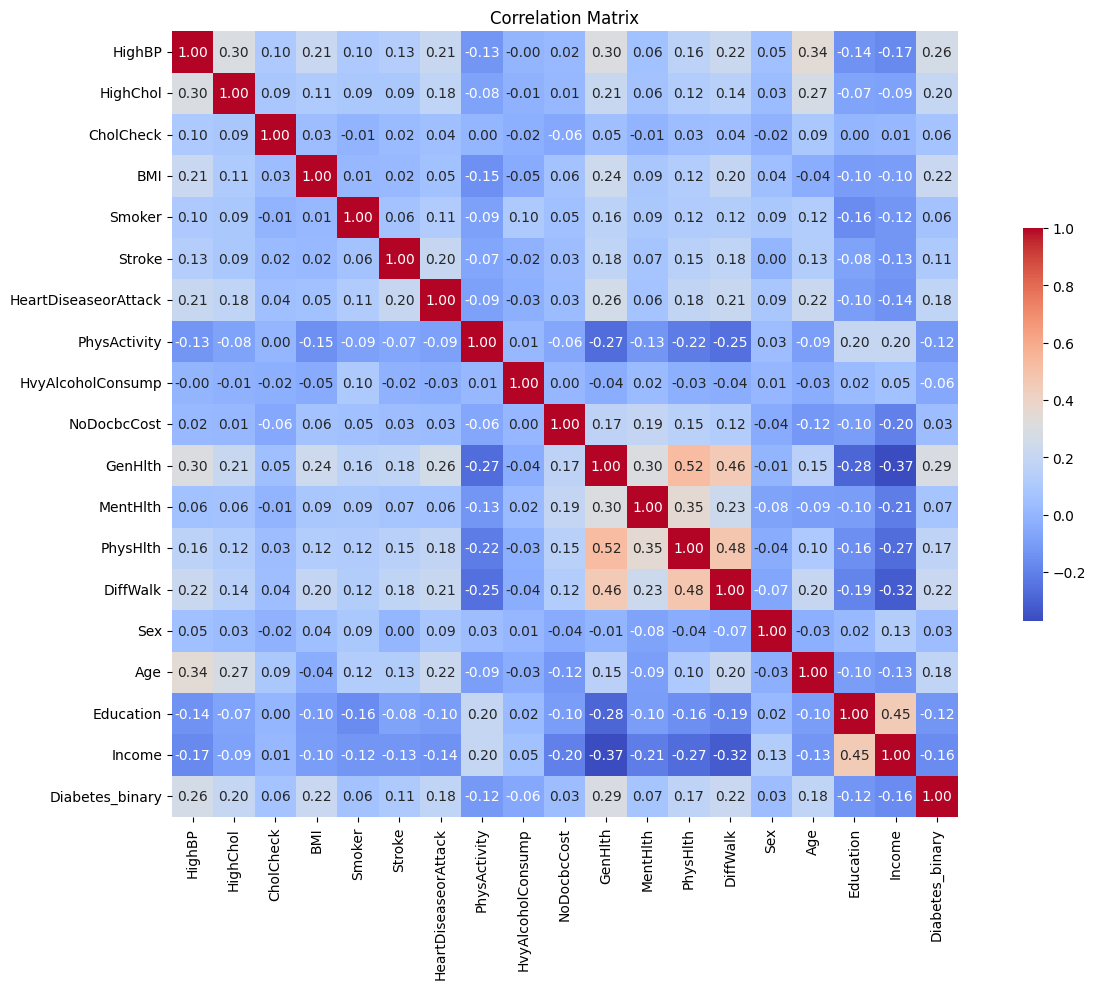

In [ ]:
# Convert selected columns to pandas for correlation
pdf_corr = df.select([
    "HighBP", "HighChol", "CholCheck", "BMI", "Smoker", "Stroke",
    "HeartDiseaseorAttack", "PhysActivity", "HvyAlcoholConsump",
    "NoDocbcCost", "GenHlth", "MentHlth", "PhysHlth", "DiffWalk",
    "Sex", "Age", "Education", "Income", "Diabetes_binary"
]).toPandas()

# Plot the correlation matrix
import seaborn as sns
plt.figure(figsize=(14, 10))
corr_matrix = pdf_corr.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .5})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


<ipython-input-11-46e3d918cc09>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AgeGroup', data=pdf_age, palette='viridis')
<ipython-input-11-46e3d918cc09>:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.countplot(x='AgeGroup', data=pdf_age, palette='viridis')


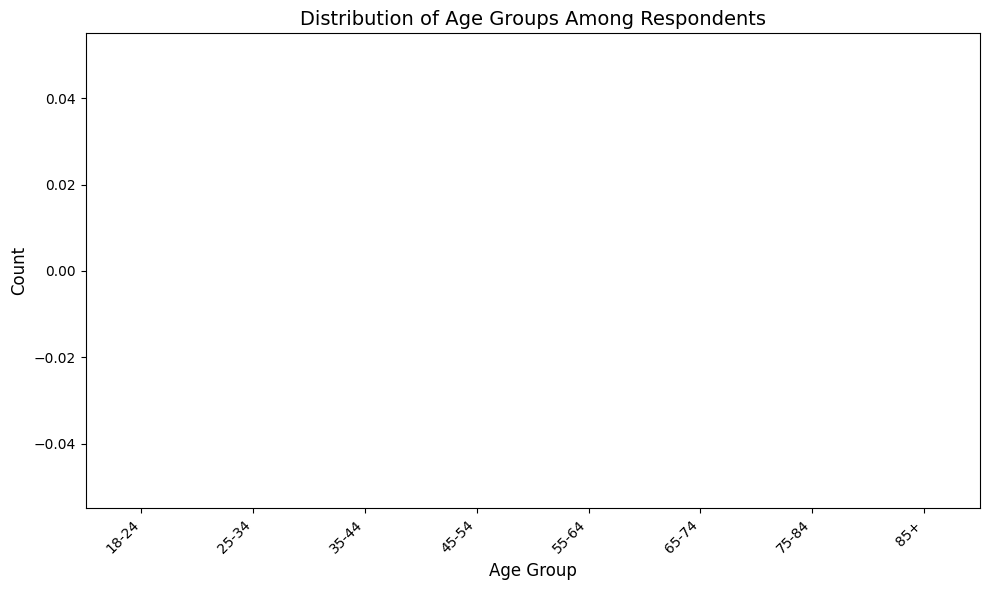

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your Spark DataFrame
pdf_age = df.select("Age").toPandas()

# Create age group categories (adjust ranges as needed)
bins = [18, 25, 35, 45, 55, 65, 75, 85, float('inf')]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+']
pdf_age['AgeGroup'] = pd.cut(pdf_age['Age'], bins=bins, labels=labels, right=False)

# Plot the distribution using a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='AgeGroup', data=pdf_age, palette='viridis')
plt.title('Distribution of Age Groups Among Respondents', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

## Step 9: Cross Tabulation — Visualizing Diabetes Across Key Features

To better understand how diabetes diagnosis varies across health-related features, we plot:
- `HighBP`: People with high blood pressure
- `GenHlth`: Self-reported general health (1 = Excellent, 5 = Poor)
- `DiffWalk`: Difficulty walking due to health problems

These stacked bar plots break down how `Diabetes_binary` is distributed within each category. It helps us spot patterns and informs potential feature selection for modeling.


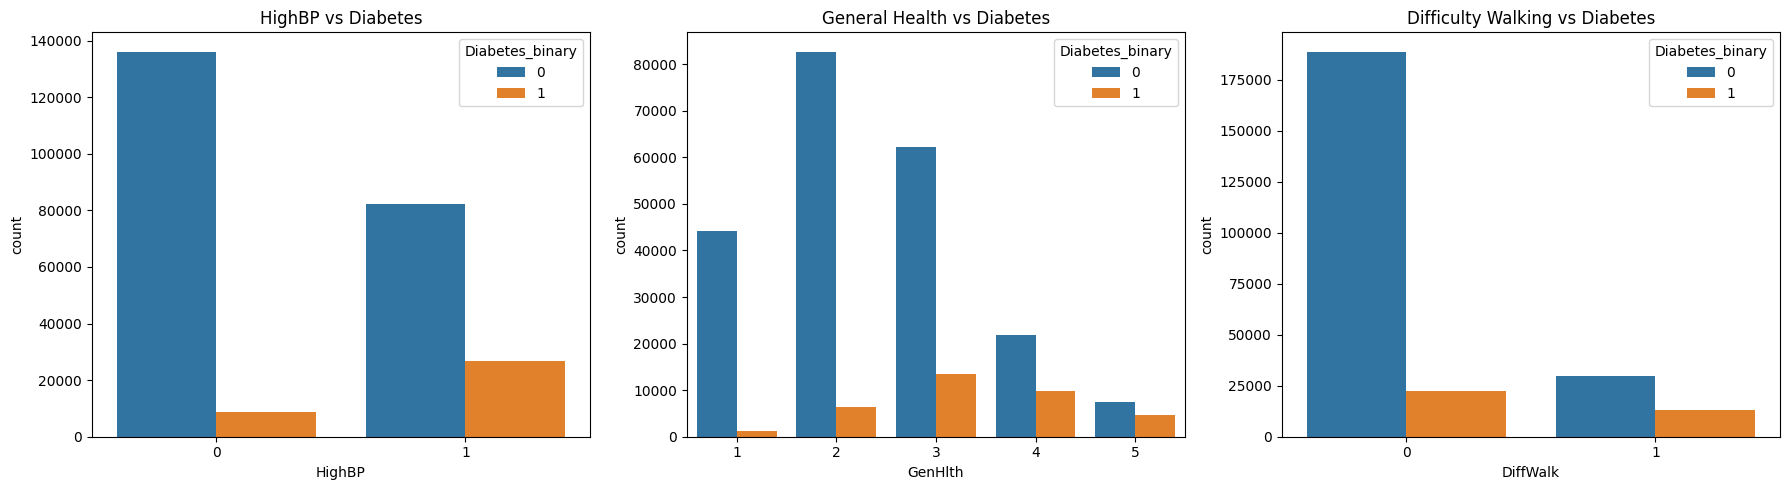

In [ ]:
# Convert relevant columns to pandas
pdf_ct = df.select("HighBP", "GenHlth", "DiffWalk", "Age", "Diabetes_binary").toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

# Set up subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# HighBP vs Diabetes
sns.countplot(x="HighBP", hue="Diabetes_binary", data=pdf_ct, ax=axs[0])
axs[0].set_title("HighBP vs Diabetes")

# GenHlth vs Diabetes
sns.countplot(x="GenHlth", hue="Diabetes_binary", data=pdf_ct, ax=axs[1])
axs[1].set_title("General Health vs Diabetes")

# DiffWalk vs Diabetes
sns.countplot(x="DiffWalk", hue="Diabetes_binary", data=pdf_ct, ax=axs[2])
axs[2].set_title("Difficulty Walking vs Diabetes")

plt.tight_layout()
plt.show()


## Step 10: EDA Summary & Modeling Readiness

Our exploratory analysis revealed key trends:

- **No missing values**: Dataset is clean and ready for modeling.
- **Class imbalance**: Diabetes diagnosis (`Diabetes_binary = 1`) is ~14% of total, indicating the need for stratified sampling or resampling techniques.
- **Strong predictors**: High blood pressure, poor general health, high BMI, and mobility difficulty are positively associated with diabetes.
- **Ordinal & socio-demographic signals**: Age, education, and income also show important but subtler trends.
- **No extreme multicollinearity**, but some clusters (GenHlth, PhysHlth, DiffWalk) require awareness in linear models.

We are now well-positioned to begin **feature engineering**, **model training**, and **evaluation** using PySpark ML or Sklearn pipelines.


# MODELING

<ipython-input-8-1250346a07bf>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Diabetes_binary', data=pdf_ct, palette=['blue', 'red'])  # Specify colors


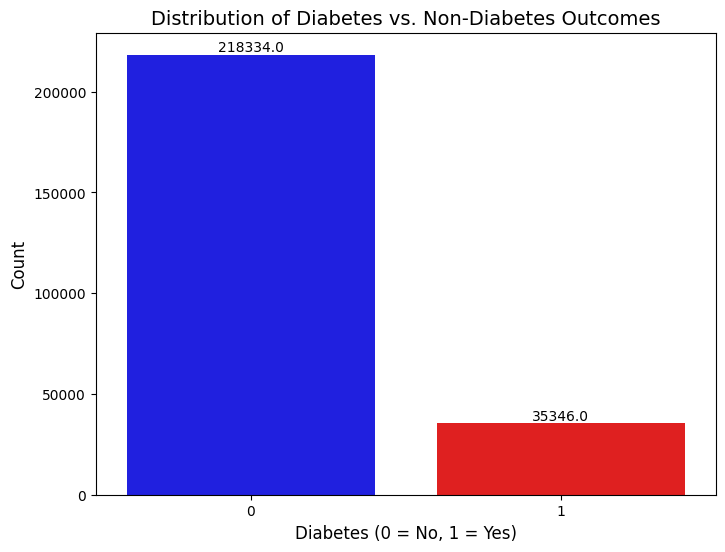

In [ ]:
# prompt: Attached this image here: distribution of the diabetes vs. non-diabetes outcomes

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# Assuming 'df' is the Spark DataFrame containing your data
# Recreate pdf_ct within the current cell to ensure it's defined
pdf_ct = df.select("HighBP", "GenHlth", "DiffWalk", "Age", "Diabetes_binary").toPandas()

# Distribution of Diabetes vs. Non-Diabetes
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Diabetes_binary', data=pdf_ct, palette=['blue', 'red'])  # Specify colors
plt.title('Distribution of Diabetes vs. Non-Diabetes Outcomes', fontsize=14)
plt.xlabel('Diabetes (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()

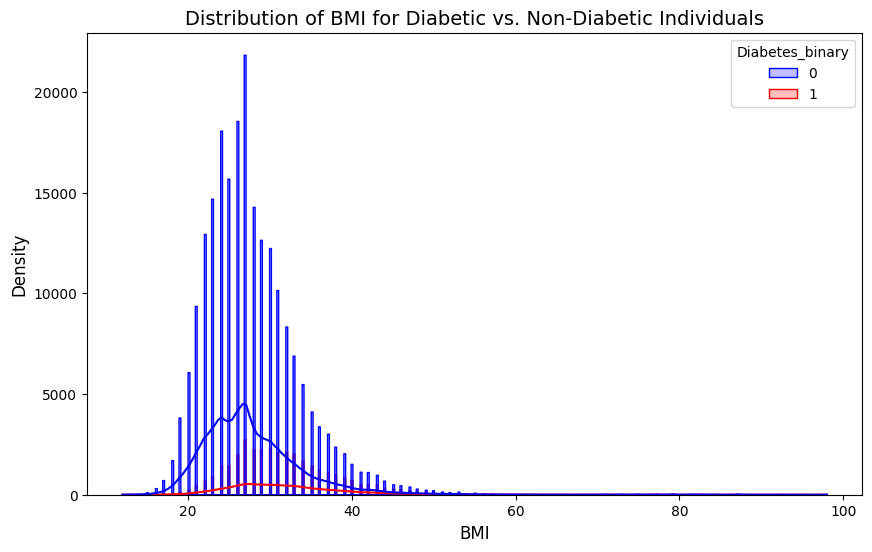

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# Assuming 'df' is the Spark DataFrame containing your data
# Recreate pdf_ct within the current cell to ensure it's defined, but include BMI
pdf_bmi = df.select("BMI", "Diabetes_binary").toPandas()

# Distribution of BMI, highlighting diabetic vs. non-diabetic
plt.figure(figsize=(10, 6))
sns.histplot(data=pdf_bmi, x="BMI", hue="Diabetes_binary",
             palette=['blue', 'red'], element="step", kde=True)  # Using histplot for distributions

plt.title('Distribution of BMI for Diabetic vs. Non-Diabetic Individuals', fontsize=14)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Density', fontsize=12)  # Changed to Density for histplot

plt.show()

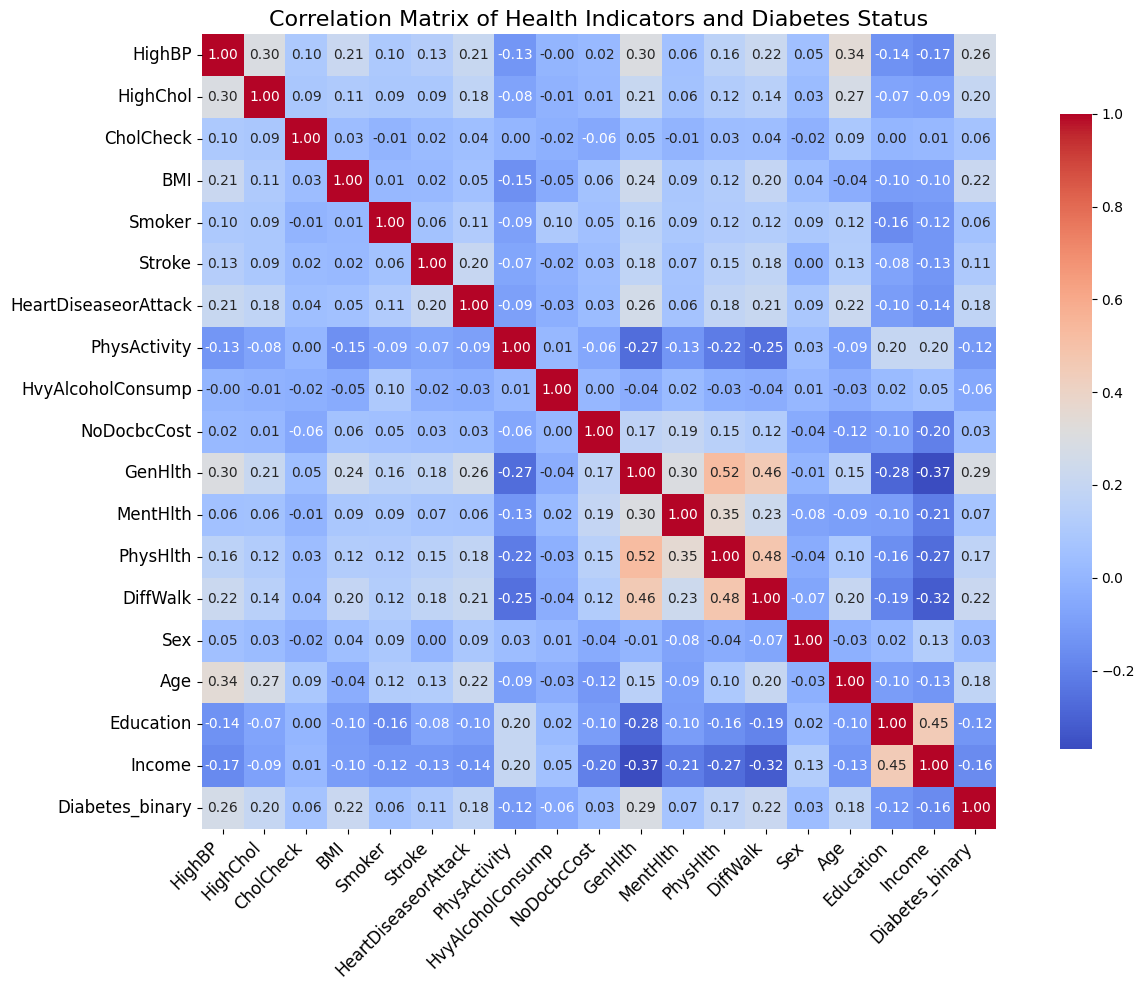

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# Assuming 'df' is the Spark DataFrame containing your data
# Select the relevant columns for correlation analysis
pdf_corr = df.select([
    "HighBP", "HighChol", "CholCheck", "BMI", "Smoker", "Stroke",
    "HeartDiseaseorAttack", "PhysActivity", "HvyAlcoholConsump",
    "NoDocbcCost", "GenHlth", "MentHlth", "PhysHlth", "DiffWalk",
    "Sex", "Age", "Education", "Income", "Diabetes_binary"
]).toPandas()

# Plot the correlation matrix
plt.figure(figsize=(14, 10))
corr_matrix = pdf_corr.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Health Indicators and Diabetes Status", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Step 1: Feature Engineering for Modeling

We prepare the data for machine learning using PySpark ML. This includes:

- **StringIndexer**: Converts categorical `Sex` into a numeric column.
- **VectorAssembler**: Combines all features into a single `features` vector.
- **Pipeline**: Chains transformations for cleaner, scalable processing.

This prepares the data in the format required by Spark MLlib models.


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Define feature columns
feature_cols = [
    "HighBP", "HighChol", "CholCheck", "BMI", "Smoker", "Stroke", "HeartDiseaseorAttack",
    "PhysActivity", "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", "GenHlth",
    "MentHlth", "PhysHlth", "DiffWalk", "Sex", "Age", "Education", "Income"
]

# Index categorical column(s)
sex_indexer = StringIndexer(inputCol="Sex", outputCol="Sex_index", handleInvalid="keep")

# Assemble features
assembler = VectorAssembler(
    inputCols=[col for col in feature_cols if col != "Sex"] + ["Sex_index"],
    outputCol="features"
)

# Define pipeline
pipeline = Pipeline(stages=[sex_indexer, assembler])

# Transform the dataset
model_input = pipeline.fit(df).transform(df)

# Final data preview
model_input.select("features", "Diabetes_binary").show(5, truncate=False)


+---------------------------------------------------------------------------------+---------------+
|features                                                                         |Diabetes_binary|
+---------------------------------------------------------------------------------+---------------+
|[1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,9.0,4.0,3.0,0.0] |0              |
|(19,[3,4,7,10,11,15,16,17],[25.0,1.0,1.0,1.0,3.0,7.0,6.0,1.0])                   |0              |
|[1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,9.0,4.0,8.0,0.0] |0              |
|(19,[0,2,3,7,9,11,15,16,17],[1.0,1.0,27.0,1.0,1.0,2.0,11.0,3.0,6.0])             |0              |
|(19,[0,1,2,3,7,9,11,12,15,16,17],[1.0,1.0,1.0,24.0,1.0,1.0,2.0,3.0,11.0,5.0,4.0])|0              |
+---------------------------------------------------------------------------------+---------------+
only showing top 5 rows



## Step 2: Train/Test Split and Logistic Regression

We train a baseline logistic regression model using PySpark ML. This includes:

- Splitting the dataset into 80% training and 20% testing.
- Training on the assembled `features` vector.
- Evaluating model performance with AUC (area under the ROC curve).
- Reviewing a confusion matrix to see prediction breakdown across true/false classes.

This sets a performance benchmark to improve upon in future models.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Split data
train_data, test_data = model_input.randomSplit([0.8, 0.2], seed=42)

# Initialize logistic regression
lr = LogisticRegression(featuresCol="features", labelCol="Diabetes_binary")

# Fit model
lr_model = lr.fit(train_data)

# Predict
predictions = lr_model.transform(test_data)

# Evaluate
evaluator = BinaryClassificationEvaluator(labelCol="Diabetes_binary")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.4f}")

# Cast predictions and labels to float
preds_and_labels = predictions.select(
    col("prediction").cast("float"),
    col("Diabetes_binary").cast("float")
).rdd

# Recalculate metrics
metrics = MulticlassMetrics(preds_and_labels)

print("Confusion Matrix:")
print(metrics.confusionMatrix().toArray())

AUC: 0.8222


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[42780.   903.]
 [ 5935.  1120.]]


**Model Performance Summary**

- **AUC:** `0.8222` — Solid baseline model performance.
- **True Negatives (42,788):** Accurately classifies most non-diabetic individuals.
- **False Positives (903):** More false alarms than other models.
- **False Negatives (5,935):** Slightly better than GBT at catching positives.
- **True Positives (1,120):** Comparable ability to detect diabetic cases.

**Insight:** Performs decently with linear assumptions, but struggles with complex patterns in the data. Higher false positive rate reduces precision.

## Step 3: Model Upgrade — Random Forest Classifier

To improve performance, we switch to a Random Forest model. This ensemble method is more flexible with:

- **Nonlinear feature interactions**
- **Handling imbalanced classes**
- **Providing feature importance**

We train a 100-tree forest with a max depth of 10 and compare AUC and confusion matrix performance against logistic regression.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize and train Random Forest
rf = RandomForestClassifier(
    labelCol="Diabetes_binary",
    featuresCol="features",
    numTrees=100,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluate AUC
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc:.4f}")

# Confusion Matrix
rf_preds_and_labels = rf_predictions.select(
    col("prediction").cast("float"),
    col("Diabetes_binary").cast("float")
).rdd

rf_metrics = MulticlassMetrics(rf_preds_and_labels)

print("Random Forest Confusion Matrix:")
print(rf_metrics.confusionMatrix().toArray())

Random Forest AUC: 0.8215
Random Forest Confusion Matrix:
[[43245.   438.]
 [ 6321.   734.]]


**Model Performance Summary**

- **AUC:** `0.8215` — Very close to logistic regression, but with added complexity.
- **True Negatives (43,245):** Highest rate of correctly identified healthy individuals.
- **False Positives (438):** Very few false alarms — high precision.
- **False Negatives (6,321):** Misses many diabetes cases.
- **True Positives (734):** Detects fewer true positives.

**Insight:** Prioritizes precision over recall — great for avoiding false positives but risky for missing diabetics. Less balanced than GBT.

## Step 4: Custom Feature Engineering — Chronic Condition Count

To enrich our model, we engineer a new feature called `ChronicCount`, which sums:

- High Blood Pressure
- High Cholesterol
- Heart Disease/Heart Attack
- Stroke

This captures the total number of chronic risk factors per individual, which can be more predictive than using them separately.

We then re-run the feature pipeline including this new feature.

In [ ]:
from pyspark.sql.functions import col

# Add new engineered feature
df = df.withColumn(
    "ChronicCount",
    col("HighBP") + col("HighChol") + col("HeartDiseaseorAttack") + col("Stroke")
)

# Updated feature list (with ChronicCount)
feature_cols = [
    "HighBP", "HighChol", "CholCheck", "BMI", "Smoker", "Stroke", "HeartDiseaseorAttack",
    "PhysActivity", "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", "GenHlth",
    "MentHlth", "PhysHlth", "DiffWalk", "Sex", "Age", "Education", "Income", "ChronicCount"
]

# Recreate pipeline
sex_indexer = StringIndexer(inputCol="Sex", outputCol="Sex_index", handleInvalid="keep")
assembler = VectorAssembler(
    inputCols=[col for col in feature_cols if col != "Sex"] + ["Sex_index"],
    outputCol="features"
)
pipeline = Pipeline(stages=[sex_indexer, assembler])

# Re-transform the data
model_input = pipeline.fit(df).transform(df)

# Preview
model_input.select("ChronicCount", "features", "Diabetes_binary").show(5, truncate=False)

+------------+----------------------------------------------------------------------------------------+---------------+
|ChronicCount|features                                                                                |Diabetes_binary|
+------------+----------------------------------------------------------------------------------------+---------------+
|2           |[1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,9.0,4.0,3.0,2.0,0.0]    |0              |
|0           |(20,[3,4,7,10,11,15,16,17],[25.0,1.0,1.0,1.0,3.0,7.0,6.0,1.0])                          |0              |
|2           |[1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,9.0,4.0,8.0,2.0,0.0]    |0              |
|1           |(20,[0,2,3,7,9,11,15,16,17,18],[1.0,1.0,27.0,1.0,1.0,2.0,11.0,3.0,6.0,1.0])             |0              |
|2           |(20,[0,1,2,3,7,9,11,12,15,16,17,18],[1.0,1.0,1.0,24.0,1.0,1.0,2.0,3.0,11.0,5.0,4.0,2.0])|0              |
+------------+--------------------------

## Step 5: Evaluating Model Impact of `ChronicCount`

We now re-train our Random Forest using the newly engineered `ChronicCount` feature. This synthetic variable summarizes chronic disease burden in a single number — and may improve classification of diabetes risk.

We re-run the training and evaluation to measure changes in AUC and confusion matrix.

In [ ]:
# Re-split since model_input changed
train_data, test_data = model_input.randomSplit([0.8, 0.2], seed=42)

# Re-train Random Forest
rf = RandomForestClassifier(
    labelCol="Diabetes_binary",
    featuresCol="features",
    numTrees=100,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Re-evaluate AUC
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest (with ChronicCount) AUC: {rf_auc:.4f}")

# Recompute confusion matrix
rf_preds_and_labels = rf_predictions.select(
    col("prediction").cast("float"),
    col("Diabetes_binary").cast("float")
).rdd

rf_metrics = MulticlassMetrics(rf_preds_and_labels)
print("Confusion Matrix (with ChronicCount):")
print(rf_metrics.confusionMatrix().toArray())

Random Forest (with ChronicCount) AUC: 0.8202
Confusion Matrix (with ChronicCount):
[[43232.   451.]
 [ 6308.   747.]]


### Step 6: Train Gradient-Boosted Tree (GBT) Model

To enhance performance, we train a **Gradient-Boosted Tree (GBT)** model.  
GBTs are an ensemble technique that build decision trees sequentially, correcting the errors of prior trees.

This approach is particularly powerful in handling:

- **Nonlinear feature relationships**
- **High-order feature interactions**
- **Imbalanced datasets**, with tunable control over model complexity

In this step, we train a GBT model using:
- `maxDepth=5` to limit tree complexity
- `maxIter=50` boosting rounds for performance
- `stepSize=0.1` to control the learning rate for generalization

This model strikes a solid balance between **accuracy** and **overfitting prevention**.

We evaluate model performance using **AUC (Area Under the ROC Curve)** — a robust metric for binary classification tasks.


In [ ]:
from pyspark.ml.classification import GBTClassifier

# Train Gradient-Boosted Tree
gbt = GBTClassifier(
    labelCol="Diabetes_binary",
    featuresCol="features",
    maxDepth=5,
    maxIter=50,
    stepSize=0.1,
    seed=42
)

gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate AUC
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"GBT AUC: {gbt_auc:.4f}")

GBT AUC: 0.8272


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

gbt_preds_and_labels = gbt_predictions.select(
    col("prediction").cast("float"),
    col("Diabetes_binary").cast("float")
).rdd

gbt_metrics = MulticlassMetrics(gbt_preds_and_labels)
print("GBT Confusion Matrix:")
print(gbt_metrics.confusionMatrix().toArray())


GBT Confusion Matrix:
[[42897.   786.]
 [ 5937.  1118.]]


In [ ]:
# Feature importances from GBT
print(gbt_model.featureImportances)

(20,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],[0.13608048643775444,0.0019222135977185319,0.02277406280481573,0.14757596861078082,0.0016042987070642582,0.002854654844916272,0.0043814947141898606,0.002767810556201101,0.03357513266188825,0.0022174575327816694,0.0015263911922858168,0.18369051517989587,0.008539374136794243,0.00921424434745987,0.01607116879821445,0.13882141238577922,0.01145791684824823,0.0426890034828835,0.20222421291758183,0.030012180242745958])


**Model Performance Summary**

- **AUC:** `0.8272` — Strong performance in distinguishing diabetic vs. non-diabetic individuals.
- **True Negatives (42,897):** Correctly identifies most non-diabetic cases.
- **False Positives (786):** Occasionally predicts diabetes when it’s not actually present.
- **False Negatives (5,937):** Misses some diabetic individuals — a common trade-off in boosting models.
- **True Positives (1,118):** Correctly detects many true diabetes cases.

**Insight:** GBT delivers the best performance among all models, handling feature interactions and nonlinearity well. There's still a risk of underdiagnosing some cases (false negatives).